# The Cat Boost Notebook notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

**Takes over from cleaning_2.ipynb**


Uses catboost. Hyperparameter tuning using optuna.


# 154 notebook!

In [218]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [219]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [220]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [221]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


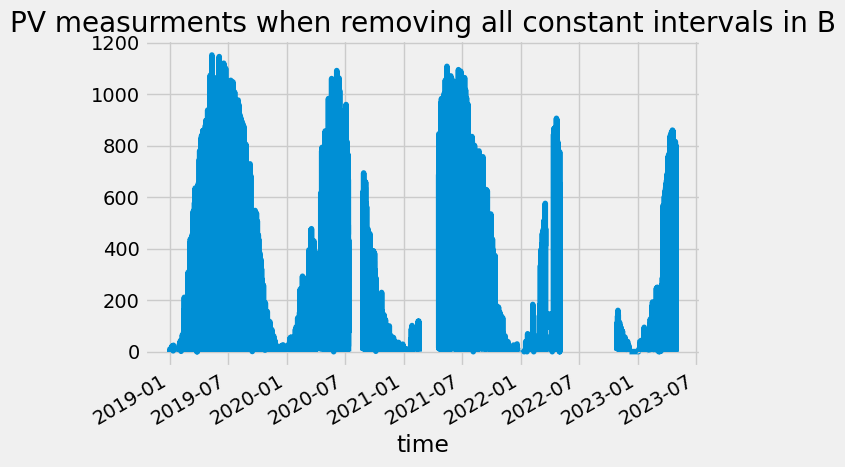

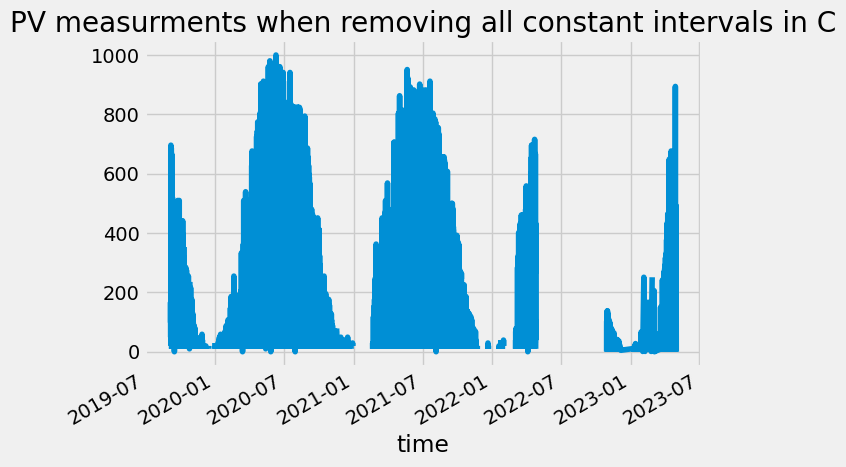

In [222]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [223]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [224]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [225]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [226]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [227]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [228]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [229]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [230]:
f = 'air_density_2m:kgm3'

In [231]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)
    #median_value = df[feature].median()

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

In [232]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa'
            
]

# 'air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'

#0.04391554145075651

for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [233]:
#median = X_train_observed_a['air_density_2m:kgm3'].median()

#outliers_indices = (X_train_observed_a['air_density_2m:kgm3'] < 1.15) | (X_train_observed_a['air_density_2m:kgm3'] > 1.41)
#X_train_observed_a.loc[outliers_indices, 'air_density_2m:kgm3'] = np.nan
#X_train_observed_a['air_density_2m:kgm3'].interpolate(method='spline', order=3, inplace=True)
#X_train_observed_a[f].plot(style='o')

In [234]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [235]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

One hot encoding on location

In [236]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [237]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [238]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,3.450000e+08


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [239]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [240]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [241]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              43484
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 45327 ROWS BEING DROPPED. THE DATASET HAS 53759 ROWS IN TOTAL.


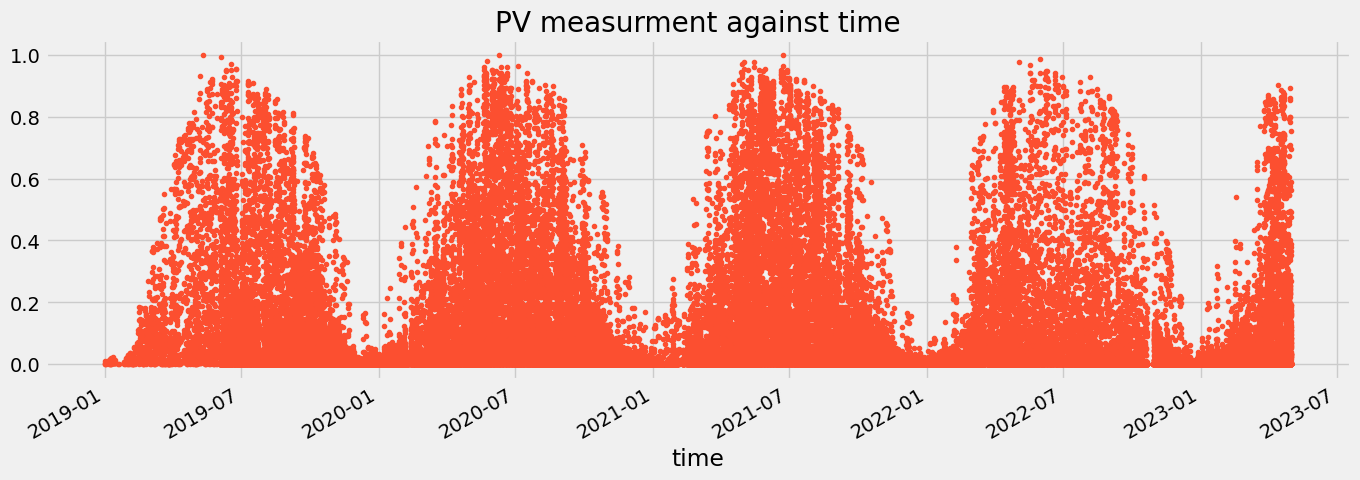

In [242]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [243]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [244]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [245]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [246]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [247]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [248]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [249]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [250]:
X_train = df[FEATURES]
y_train = df[TARGET]

In [251]:
import optuna
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 100.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        'loss_function':'MAE'
    }

    if param["grow_policy"] == "Lossguide":
        param["max_leaves"] = trial.suggest_int("max_leaves", 31, 1024, log=True)



    cv_dataset = Pool(data=X_train, label=y_train)


    scores = cv(cv_dataset,
                    params=param,
                    fold_count=5,
                    plot=False,
                    type="TimeSeries",
                    verbose=False)
    

    # Extract the best score
    best_score = np.min(scores['test-MAE-mean'])
    
    return best_score

In [252]:
trials = 60

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

[I 2023-10-22 22:58:41,762] A new study created in memory with name: no-name-d33705c5-4d92-492a-9d29-4e41d3b7baa7
  0%|          | 0/60 [00:00<?, ?it/s]

Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]

bestTest = 0.05243389078
bestIteration = 168

Training on fold [1/5]

bestTest = 0.1342942484
bestIteration = 845

Training on fold [1/5]

bestTest = 0.05421948829
bestIteration = 735

Training on fold [1/5]

bestTest = 0.03633330538
bestIteration = 760

Training on fold [2/5]

bestTest = 0.0788931508
bestIteration = 845

Training on fold [2/5]

bestTest = 0.05398573109
bestIteration = 1206

Training on fold [1/5]

bestTest = 0.06084899148
bestIteration = 759

Training on fold [3/5]

bestTest = 0.03439113399
bestIteration = 834

Training on fold [2/5]

bestTest = 0.1922894833
bestIteration = 845

Training on fold [3/5]

bestTest = 0.1201331251
bestIteration = 707

Training on fold [1/5]

bestTest = 0.03506164216
bestIteration = 765

Training on fold [4/5]

bestTest = 0.08263112088
bestIteration = 845

Tr

Best trial: 0. Best value: 0.0444157:   2%|▏         | 1/60 [01:17<1:15:47, 77.08s/it]


bestTest = 0.0359763887
bestIteration = 769

[I 2023-10-22 22:59:58,840] Trial 0 finished with value: 0.044415669303025755 and parameters: {'iterations': 771, 'learning_rate': 0.08699014071587137, 'depth': 3, 'colsample_bylevel': 0.47247197773467015, 'min_data_in_leaf': 107, 'l2_leaf_reg': 7.472940292847188e-07, 'border_count': 83, 'random_strength': 8.166816400454767, 'bagging_temperature': 94.8194121248964, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.044415669303025755.
Training on fold [0/5]

bestTest = 0.03691303341
bestIteration = 1206

Training on fold [2/5]

bestTest = 0.1412610822
bestIteration = 652

Training on fold [1/5]


Best trial: 0. Best value: 0.0444157:   3%|▎         | 2/60 [01:36<41:55, 43.38s/it]  


bestTest = 0.07464664066
bestIteration = 845

[I 2023-10-22 23:00:18,629] Trial 4 finished with value: 0.11255092880584398 and parameters: {'iterations': 846, 'learning_rate': 0.0003955048995108517, 'depth': 4, 'colsample_bylevel': 0.18991907066690375, 'min_data_in_leaf': 267, 'l2_leaf_reg': 0.00011420183377084837, 'border_count': 103, 'random_strength': 7.403515543612629, 'bagging_temperature': 33.674357772016485, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.044415669303025755.
Training on fold [0/5]

bestTest = 0.03319430436
bestIteration = 835

Training on fold [4/5]

bestTest = 0.06800373267
bestIteration = 1206

Training on fold [3/5]


Best trial: 2. Best value: 0.0432484:   5%|▌         | 3/60 [02:13<38:14, 40.25s/it]


bestTest = 0.0333171729
bestIteration = 835

[I 2023-10-22 23:00:55,166] Trial 2 finished with value: 0.04324841390832804 and parameters: {'iterations': 836, 'learning_rate': 0.006711682356367336, 'depth': 10, 'colsample_bylevel': 0.3199727292927418, 'min_data_in_leaf': 267, 'l2_leaf_reg': 0.00661669463179953, 'border_count': 120, 'random_strength': 1.6670217577111013, 'bagging_temperature': 80.72446213012212, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]

bestTest = 0.05262821444
bestIteration = 829

Training on fold [1/5]

bestTest = 0.07056433075
bestIteration = 707

Training on fold [2/5]

bestTest = 0.03749233406
bestIteration = 919

Training on fold [2/5]

bestTest = 0.1260997756
bestIteration = 757

Training on fold [1/5]

bestTest = 0.06805654006
bestIteration = 916

Training on fold [3/5]

bestTest = 0.03793648531
bestIteration = 1206

Training on fold [4/5]

bestTest = 0.03936837195
bestIteration = 916

Training on f

Best trial: 2. Best value: 0.0432484:   7%|▋         | 4/60 [03:04<41:43, 44.70s/it]


bestTest = 0.04083496897
bestIteration = 917

[I 2023-10-22 23:01:46,690] Trial 10 finished with value: 0.04768055707784715 and parameters: {'iterations': 920, 'learning_rate': 0.05446227795697808, 'depth': 1, 'colsample_bylevel': 0.7628681228182452, 'min_data_in_leaf': 287, 'l2_leaf_reg': 1.1582135437033608e-05, 'border_count': 193, 'random_strength': 5.551458325711333, 'bagging_temperature': 31.96914921265893, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]


Best trial: 2. Best value: 0.0432484:   8%|▊         | 5/60 [03:54<42:41, 46.57s/it]


bestTest = 0.03903935882
bestIteration = 1206

[I 2023-10-22 23:02:36,568] Trial 6 finished with value: 0.047175668261632143 and parameters: {'iterations': 1207, 'learning_rate': 0.004244788014411056, 'depth': 3, 'colsample_bylevel': 0.24695245873082255, 'min_data_in_leaf': 39, 'l2_leaf_reg': 0.009457045657100075, 'border_count': 26, 'random_strength': 4.981232935736285, 'bagging_temperature': 92.8233891911261, 'grow_policy': 'Lossguide', 'max_leaves': 36}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]

bestTest = 0.05490646126
bestIteration = 147

Training on fold [1/5]

bestTest = 0.08585257502
bestIteration = 652

Training on fold [2/5]

bestTest = 0.07451497357
bestIteration = 757

Training on fold [2/5]

bestTest = 0.1695791191
bestIteration = 707

Training on fold [3/5]

bestTest = 0.0348692026
bestIteration = 786

Training on fold [2/5]

bestTest = 0.03454439939
bestIteration = 750

Training on fold [2/5]

bestTest = 0.05397206408
bestIteration = 111



Best trial: 2. Best value: 0.0432484:  10%|█         | 6/60 [11:17<2:43:05, 181.22s/it]


bestTest = 0.03204005944
bestIteration = 484

[I 2023-10-22 23:09:59,154] Trial 11 finished with value: 0.04410562894458239 and parameters: {'iterations': 1344, 'learning_rate': 0.035620214520846044, 'depth': 12, 'colsample_bylevel': 0.650365163912426, 'min_data_in_leaf': 50, 'l2_leaf_reg': 1.515688061649296e-06, 'border_count': 198, 'random_strength': 8.116316223496852, 'bagging_temperature': 19.745776678301972, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]

bestTest = 0.03601082651
bestIteration = 511

Training on fold [2/5]


Best trial: 2. Best value: 0.0432484:  12%|█▏        | 7/60 [12:11<2:03:26, 139.75s/it]


bestTest = 0.06769229214
bestIteration = 707

[I 2023-10-22 23:10:53,537] Trial 7 finished with value: 0.10043039329329626 and parameters: {'iterations': 708, 'learning_rate': 0.0006369372253749662, 'depth': 10, 'colsample_bylevel': 0.2636055163637405, 'min_data_in_leaf': 298, 'l2_leaf_reg': 5.047484296409073e-08, 'border_count': 63, 'random_strength': 9.70745405058995, 'bagging_temperature': 66.92710547907724, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]


Best trial: 2. Best value: 0.0432484:  13%|█▎        | 8/60 [13:24<1:42:33, 118.33s/it]


bestTest = 0.07181918026
bestIteration = 757

[I 2023-10-22 23:12:06,000] Trial 8 finished with value: 0.10678325804365303 and parameters: {'iterations': 758, 'learning_rate': 0.0004941884170619928, 'depth': 12, 'colsample_bylevel': 0.6174567497741021, 'min_data_in_leaf': 65, 'l2_leaf_reg': 3.2835874816428644e-08, 'border_count': 80, 'random_strength': 0.4243575235026435, 'bagging_temperature': 7.831849709489158, 'grow_policy': 'Lossguide', 'max_leaves': 69}. Best is trial 2 with value: 0.04324841390832804.
Training on fold [0/5]

bestTest = 0.03211015958
bestIteration = 750

Training on fold [4/5]

bestTest = 0.05816684888
bestIteration = 287

Training on fold [1/5]

bestTest = 0.1365669486
bestIteration = 509

Training on fold [1/5]

bestTest = 0.08859392006
bestIteration = 652

Training on fold [4/5]

bestTest = 0.08187644544
bestIteration = 509

Training on fold [2/5]

bestTest = 0.09091408017
bestIteration = 1244

Training on fold [1/5]

bestTest = 0.03425270628
bestIteration = 5

Best trial: 9. Best value: 0.0421023:  15%|█▌        | 9/60 [18:23<2:28:39, 174.89s/it]


bestTest = 0.03220408546
bestIteration = 750

[I 2023-10-22 23:17:05,251] Trial 9 finished with value: 0.04210234498505695 and parameters: {'iterations': 751, 'learning_rate': 0.016913499349705742, 'depth': 16, 'colsample_bylevel': 0.2721355937354519, 'min_data_in_leaf': 228, 'l2_leaf_reg': 0.004202863074314499, 'border_count': 143, 'random_strength': 1.477842712809352, 'bagging_temperature': 9.694622080085669, 'grow_policy': 'Lossguide', 'max_leaves': 85}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.06102560217
bestIteration = 421

Training on fold [3/5]

bestTest = 0.08482989692
bestIteration = 509

Training on fold [4/5]

bestTest = 0.03266302769
bestIteration = 619

Training on fold [4/5]

bestTest = 0.05046750516
bestIteration = 1423

Training on fold [1/5]


Best trial: 9. Best value: 0.0421023:  17%|█▋        | 10/60 [22:32<2:44:50, 197.81s/it]


bestTest = 0.0763557676
bestIteration = 509

[I 2023-10-22 23:21:14,390] Trial 15 finished with value: 0.11481509075437688 and parameters: {'iterations': 510, 'learning_rate': 0.000526697340892457, 'depth': 10, 'colsample_bylevel': 0.1075896722507697, 'min_data_in_leaf': 292, 'l2_leaf_reg': 3.3576376392322227e-07, 'border_count': 217, 'random_strength': 4.967881009356474, 'bagging_temperature': 20.903466413255543, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.05340801909
bestIteration = 1244

Training on fold [2/5]


Best trial: 9. Best value: 0.0421023:  18%|█▊        | 11/60 [23:14<2:02:37, 150.15s/it]


bestTest = 0.07963892711
bestIteration = 652

[I 2023-10-22 23:21:56,466] Trial 5 finished with value: 0.11917726584957314 and parameters: {'iterations': 653, 'learning_rate': 0.0002875841475399336, 'depth': 13, 'colsample_bylevel': 0.48708085263203277, 'min_data_in_leaf': 124, 'l2_leaf_reg': 0.0003467502868174793, 'border_count': 29, 'random_strength': 0.8979811363357205, 'bagging_temperature': 80.5621031659174, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.03602384096
bestIteration = 188

Training on fold [2/5]


Best trial: 9. Best value: 0.0421023:  20%|██        | 12/60 [23:29<1:27:14, 109.05s/it]


bestTest = 0.03198956653
bestIteration = 658

[I 2023-10-22 23:22:11,507] Trial 14 finished with value: 0.044314682506148104 and parameters: {'iterations': 1153, 'learning_rate': 0.020836192736665947, 'depth': 15, 'colsample_bylevel': 0.2342322857080347, 'min_data_in_leaf': 186, 'l2_leaf_reg': 0.5291370517783994, 'border_count': 108, 'random_strength': 4.412481019846643, 'bagging_temperature': 13.784220926231484, 'grow_policy': 'SymmetricTree'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.03375389719
bestIteration = 428

Training on fold [4/5]

bestTest = 0.05053384277
bestIteration = 701

Training on fold [1/5]

bestTest = 0.03545677378
bestIteration = 1480

Training on fold [2/5]

bestTest = 0.05145698106
bestIteration = 709

Training on fold [1/5]

bestTest = 0.05135435037
bestIteration = 377

Training on fold [1/5]

bestTest = 0.03491160835
bestIteration = 1057

Training on fold [2/5]

bestTest = 0.03261294739
bestIteration = 707

Training

Best trial: 9. Best value: 0.0421023:  22%|██▏       | 13/60 [30:09<2:34:28, 197.19s/it]


bestTest = 0.03271421515
bestIteration = 380

[I 2023-10-22 23:28:51,527] Trial 12 finished with value: 0.04417334336184653 and parameters: {'iterations': 1276, 'learning_rate': 0.09139011387136178, 'depth': 12, 'colsample_bylevel': 0.9355400643487547, 'min_data_in_leaf': 150, 'l2_leaf_reg': 1.8624940508963315e-06, 'border_count': 211, 'random_strength': 9.416694054341434, 'bagging_temperature': 57.397333425689986, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.06027492055
bestIteration = 1059

Training on fold [3/5]

bestTest = 0.07507808408
bestIteration = 1053

Training on fold [1/5]

bestTest = 0.04578369751
bestIteration = 1054

Training on fold [2/5]

bestTest = 0.03450778625
bestIteration = 1094

Training on fold [2/5]

bestTest = 0.1061750112
bestIteration = 1054

Training on fold [3/5]

bestTest = 0.0512149303
bestIteration = 1054

Training on fold [4/5]


Best trial: 9. Best value: 0.0421023:  23%|██▎       | 14/60 [31:27<2:03:34, 161.18s/it]


bestTest = 0.04884124377
bestIteration = 1054

[I 2023-10-22 23:30:09,487] Trial 20 finished with value: 0.06541860820853435 and parameters: {'iterations': 1055, 'learning_rate': 0.011101687765977244, 'depth': 7, 'colsample_bylevel': 0.011907669445425317, 'min_data_in_leaf': 226, 'l2_leaf_reg': 0.009593070867029986, 'border_count': 151, 'random_strength': 2.01230769471171, 'bagging_temperature': 43.271876823316816, 'grow_policy': 'Lossguide', 'max_leaves': 379}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.03397714439
bestIteration = 1058

Training on fold [2/5]

bestTest = 0.03348397558
bestIteration = 1060

Training on fold [4/5]

bestTest = 0.0590441525
bestIteration = 1244

Training on fold [4/5]

bestTest = 0.05120825629
bestIteration = 650

Training on fold [1/5]

bestTest = 0.03372214089
bestIteration = 1484

Training on fold [4/5]

bestTest = 0.06762938834
bestIteration = 182

Training on fold [3/5]


Best trial: 9. Best value: 0.0421023:  25%|██▌       | 15/60 [35:57<2:25:30, 194.01s/it]


bestTest = 0.0318982652
bestIteration = 831

[I 2023-10-22 23:34:39,572] Trial 3 finished with value: 0.0431641280171077 and parameters: {'iterations': 1091, 'learning_rate': 0.027303873295585517, 'depth': 15, 'colsample_bylevel': 0.0849796988272959, 'min_data_in_leaf': 29, 'l2_leaf_reg': 2.2721315179643823e-06, 'border_count': 195, 'random_strength': 1.81722275267989, 'bagging_temperature': 41.532118896225825, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.0657314547
bestIteration = 1472

Training on fold [1/5]

bestTest = 0.04338347454
bestIteration = 1473

Training on fold [2/5]

bestTest = 0.08728629842
bestIteration = 1473

Training on fold [3/5]


Best trial: 9. Best value: 0.0421023:  27%|██▋       | 16/60 [36:52<1:51:33, 152.12s/it]


bestTest = 0.03371328996
bestIteration = 1058

[I 2023-10-22 23:35:34,417] Trial 19 finished with value: 0.042619679449685165 and parameters: {'iterations': 1061, 'learning_rate': 0.008562659041973654, 'depth': 7, 'colsample_bylevel': 0.9950423602387279, 'min_data_in_leaf': 215, 'l2_leaf_reg': 0.021988237147976215, 'border_count': 154, 'random_strength': 2.112698566898434, 'bagging_temperature': 59.5721484566054, 'grow_policy': 'Lossguide', 'max_leaves': 374}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.04729178226
bestIteration = 1473

Training on fold [4/5]

bestTest = 0.0617920975
bestIteration = 1084

Training on fold [3/5]

bestTest = 0.03457054518
bestIteration = 999

Training on fold [2/5]


Best trial: 9. Best value: 0.0421023:  28%|██▊       | 17/60 [37:39<1:26:17, 120.41s/it]


bestTest = 0.04655732037
bestIteration = 1473

[I 2023-10-22 23:36:21,083] Trial 22 finished with value: 0.05805027341656819 and parameters: {'iterations': 1474, 'learning_rate': 0.01602594956487398, 'depth': 16, 'colsample_bylevel': 0.01021418099779256, 'min_data_in_leaf': 5, 'l2_leaf_reg': 3.479922859015355e-05, 'border_count': 249, 'random_strength': 2.633112348458649, 'bagging_temperature': 7.968009873055816, 'grow_policy': 'Lossguide', 'max_leaves': 146}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.0610238115
bestIteration = 954

Training on fold [1/5]


Best trial: 9. Best value: 0.0421023:  30%|███       | 18/60 [38:51<1:14:02, 105.77s/it]


bestTest = 0.05539785955
bestIteration = 1244

[I 2023-10-22 23:37:32,774] Trial 13 finished with value: 0.07875536289751221 and parameters: {'iterations': 1245, 'learning_rate': 0.0007121521219555276, 'depth': 15, 'colsample_bylevel': 0.8574433494890049, 'min_data_in_leaf': 167, 'l2_leaf_reg': 2.238567497111068, 'border_count': 37, 'random_strength': 2.986143535490191, 'bagging_temperature': 12.858477755617837, 'grow_policy': 'Lossguide', 'max_leaves': 95}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]


Best trial: 9. Best value: 0.0421023:  32%|███▏      | 19/60 [38:59<52:19, 76.57s/it]   


bestTest = 0.03426871491
bestIteration = 1482

[I 2023-10-22 23:37:41,322] Trial 16 finished with value: 0.0430660118551112 and parameters: {'iterations': 1485, 'learning_rate': 0.005073014816880623, 'depth': 8, 'colsample_bylevel': 0.8105607061654965, 'min_data_in_leaf': 289, 'l2_leaf_reg': 0.03539099606401789, 'border_count': 54, 'random_strength': 3.673145317035695, 'bagging_temperature': 66.20161809283583, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.06126833123
bestIteration = 972

Training on fold [1/5]

bestTest = 0.06157857414
bestIteration = 1027

Training on fold [3/5]

bestTest = 0.05163223817
bestIteration = 606

Training on fold [1/5]

bestTest = 0.05999304041
bestIteration = 953

Training on fold [1/5]

bestTest = 0.03869980883
bestIteration = 954

Training on fold [2/5]

bestTest = 0.03511112472
bestIteration = 691

Training on fold [2/5]

bestTest = 0.03887374653
bestIteration = 972

Training on fold

Best trial: 9. Best value: 0.0421023:  33%|███▎      | 20/60 [48:38<2:31:33, 227.34s/it]


bestTest = 0.03241833546
bestIteration = 985

[I 2023-10-22 23:47:20,071] Trial 26 finished with value: 0.04269903483041374 and parameters: {'iterations': 986, 'learning_rate': 0.00972164003832339, 'depth': 6, 'colsample_bylevel': 0.9726372095404301, 'min_data_in_leaf': 204, 'l2_leaf_reg': 0.0006442056131161298, 'border_count': 152, 'random_strength': 0.03220998395505603, 'bagging_temperature': 3.851777633272225, 'grow_policy': 'Lossguide', 'max_leaves': 884}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.0764623645
bestIteration = 586

Training on fold [1/5]

bestTest = 0.03984387761
bestIteration = 953

Training on fold [4/5]

bestTest = 0.03358712822
bestIteration = 298

Training on fold [4/5]

bestTest = 0.04472126336
bestIteration = 586

Training on fold [2/5]

bestTest = 0.03180831796
bestIteration = 1065

Training on fold [4/5]


Best trial: 9. Best value: 0.0421023:  35%|███▌      | 21/60 [50:49<2:08:55, 198.34s/it]


bestTest = 0.0408852683
bestIteration = 954

[I 2023-10-22 23:49:30,803] Trial 23 finished with value: 0.052648592643641544 and parameters: {'iterations': 955, 'learning_rate': 0.002133605352899444, 'depth': 7, 'colsample_bylevel': 0.9999717190425932, 'min_data_in_leaf': 203, 'l2_leaf_reg': 8.115097657867617, 'border_count': 151, 'random_strength': 3.398973125622931, 'bagging_temperature': 0.03095330233784388, 'grow_policy': 'Lossguide', 'max_leaves': 814}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.105460424
bestIteration = 586

Training on fold [3/5]


Best trial: 9. Best value: 0.0421023:  37%|███▋      | 22/60 [51:34<1:36:30, 152.38s/it]


bestTest = 0.04102086066
bestIteration = 972

[I 2023-10-22 23:50:16,001] Trial 24 finished with value: 0.052982463230780805 and parameters: {'iterations': 973, 'learning_rate': 0.002057842935542264, 'depth': 7, 'colsample_bylevel': 0.9501148718083161, 'min_data_in_leaf': 214, 'l2_leaf_reg': 3.4265047739804553, 'border_count': 156, 'random_strength': 3.2352141337652265, 'bagging_temperature': 0.8092082970811774, 'grow_policy': 'Lossguide', 'max_leaves': 930}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.05066704621
bestIteration = 558

Training on fold [1/5]

bestTest = 0.0505968738
bestIteration = 552

Training on fold [1/5]

bestTest = 0.04869904329
bestIteration = 586

Training on fold [4/5]

bestTest = 0.03539765753
bestIteration = 965

Training on fold [2/5]

bestTest = 0.03510384415
bestIteration = 573

Training on fold [2/5]


Best trial: 9. Best value: 0.0421023:  38%|███▊      | 23/60 [53:27<1:26:41, 140.57s/it]


bestTest = 0.03248540981
bestIteration = 999

[I 2023-10-22 23:52:09,033] Trial 21 finished with value: 0.042285836151058874 and parameters: {'iterations': 1000, 'learning_rate': 0.008609543677511457, 'depth': 16, 'colsample_bylevel': 0.39180413361842814, 'min_data_in_leaf': 211, 'l2_leaf_reg': 0.9133403698222351, 'border_count': 144, 'random_strength': 2.3468098956694985, 'bagging_temperature': 1.9741011470980494, 'grow_policy': 'Lossguide', 'max_leaves': 145}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]


Best trial: 9. Best value: 0.0421023:  40%|████      | 24/60 [53:37<1:00:54, 101.51s/it]


bestTest = 0.03971638456
bestIteration = 953

[I 2023-10-22 23:52:19,412] Trial 25 finished with value: 0.05153593397467384 and parameters: {'iterations': 954, 'learning_rate': 0.0019346734686279067, 'depth': 7, 'colsample_bylevel': 0.9912318730793808, 'min_data_in_leaf': 208, 'l2_leaf_reg': 0.12810485093036272, 'border_count': 158, 'random_strength': 0.23891662908506772, 'bagging_temperature': 57.27330323059754, 'grow_policy': 'Lossguide', 'max_leaves': 841}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]


Best trial: 9. Best value: 0.0421023:  42%|████▏     | 25/60 [54:13<47:41, 81.75s/it]   


bestTest = 0.04690927085
bestIteration = 586

[I 2023-10-22 23:52:55,057] Trial 27 finished with value: 0.0644504731984066 and parameters: {'iterations': 587, 'learning_rate': 0.0021594441746064464, 'depth': 6, 'colsample_bylevel': 0.38498779503093894, 'min_data_in_leaf': 227, 'l2_leaf_reg': 0.4161764443049243, 'border_count': 156, 'random_strength': 1.1049090303537925, 'bagging_temperature': 48.12609868079247, 'grow_policy': 'Lossguide', 'max_leaves': 276}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.06084002039
bestIteration = 574

Training on fold [3/5]

bestTest = 0.06060144181
bestIteration = 1023

Training on fold [3/5]

bestTest = 0.05132707266
bestIteration = 350

Training on fold [1/5]

bestTest = 0.06976504359
bestIteration = 587

Training on fold [1/5]

bestTest = 0.03346309005
bestIteration = 574

Training on fold [4/5]

bestTest = 0.03362836657
bestIteration = 1021

Training on fold [4/5]

bestTest = 0.05155952616
bestIteration = 

Best trial: 9. Best value: 0.0421023:  43%|████▎     | 26/60 [57:04<1:01:31, 108.56s/it]


bestTest = 0.03145164382
bestIteration = 1091

[I 2023-10-22 23:55:46,181] Trial 18 finished with value: 0.04229519536573499 and parameters: {'iterations': 1095, 'learning_rate': 0.010035896357207212, 'depth': 16, 'colsample_bylevel': 0.3498044127024947, 'min_data_in_leaf': 207, 'l2_leaf_reg': 1.2820148275119658, 'border_count': 149, 'random_strength': 2.2614934867605996, 'bagging_temperature': 58.79595379440267, 'grow_policy': 'Lossguide', 'max_leaves': 405}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]


Best trial: 9. Best value: 0.0421023:  45%|████▌     | 27/60 [57:15<43:38, 79.36s/it]   


bestTest = 0.03395368648
bestIteration = 574

[I 2023-10-22 23:55:57,418] Trial 29 finished with value: 0.04279331215548314 and parameters: {'iterations': 575, 'learning_rate': 0.0096370806174679, 'depth': 6, 'colsample_bylevel': 0.8750005237015532, 'min_data_in_leaf': 240, 'l2_leaf_reg': 0.000864022922407019, 'border_count': 169, 'random_strength': 0.36156494617458534, 'bagging_temperature': 26.04735802775642, 'grow_policy': 'Lossguide', 'max_leaves': 310}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]


Best trial: 9. Best value: 0.0421023:  47%|████▋     | 28/60 [57:47<34:42, 65.08s/it]


bestTest = 0.03431118115
bestIteration = 1006

[I 2023-10-22 23:56:29,163] Trial 28 finished with value: 0.042963449138186165 and parameters: {'iterations': 1024, 'learning_rate': 0.009540818959525072, 'depth': 5, 'colsample_bylevel': 0.9770621889252549, 'min_data_in_leaf': 222, 'l2_leaf_reg': 0.0008304875569874963, 'border_count': 155, 'random_strength': 0.14481683232559694, 'bagging_temperature': 25.21579426544344, 'grow_policy': 'Lossguide', 'max_leaves': 943}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.05151195949
bestIteration = 429

Training on fold [1/5]

bestTest = 0.05103257489
bestIteration = 321

Training on fold [1/5]

bestTest = 0.08101814163
bestIteration = 585

Training on fold [3/5]

bestTest = 0.05991845686
bestIteration = 584

Training on fold [3/5]

bestTest = 0.05156095353
bestIteration = 313

Training on fold [1/5]

bestTest = 0.03480109444
bestIteration = 1097

Training on fold [2/5]


Best trial: 9. Best value: 0.0421023:  48%|████▊     | 29/60 [1:01:37<59:08, 114.45s/it]


bestTest = 0.03124510431
bestIteration = 1091

[I 2023-10-23 00:00:18,824] Trial 17 finished with value: 0.04216931648860827 and parameters: {'iterations': 1092, 'learning_rate': 0.014706921990264162, 'depth': 16, 'colsample_bylevel': 0.9789061451067331, 'min_data_in_leaf': 197, 'l2_leaf_reg': 3.7432741419509945, 'border_count': 155, 'random_strength': 1.9859665030337479, 'bagging_temperature': 3.092122539617371, 'grow_policy': 'Lossguide', 'max_leaves': 397}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.03435961333
bestIteration = 882

Training on fold [2/5]

bestTest = 0.03405753775
bestIteration = 780

Training on fold [2/5]

bestTest = 0.03417561331
bestIteration = 745

Training on fold [2/5]

bestTest = 0.04174424226
bestIteration = 599

Training on fold [4/5]

bestTest = 0.03183147572
bestIteration = 584

Training on fold [4/5]

bestTest = 0.05263523134
bestIteration = 105

Training on fold [1/5]


Best trial: 9. Best value: 0.0421023:  50%|█████     | 30/60 [1:04:31<1:06:10, 132.34s/it]


bestTest = 0.03267483055
bestIteration = 235

[I 2023-10-23 00:03:12,908] Trial 1 finished with value: 0.04562501835001378 and parameters: {'iterations': 1383, 'learning_rate': 0.05556093508367595, 'depth': 15, 'colsample_bylevel': 0.46649509518167975, 'min_data_in_leaf': 21, 'l2_leaf_reg': 0.0004160647178537362, 'border_count': 122, 'random_strength': 9.404064488212287, 'bagging_temperature': 64.77444011805184, 'grow_policy': 'Depthwise'}. Best is trial 9 with value: 0.04210234498505695.
Training on fold [0/5]

bestTest = 0.06030348494
bestIteration = 1087

Training on fold [3/5]

bestTest = 0.03540120267
bestIteration = 142

Training on fold [2/5]

bestTest = 0.05944309296
bestIteration = 657

Training on fold [3/5]

bestTest = 0.05993031345
bestIteration = 879

Training on fold [3/5]

bestTest = 0.05159792471
bestIteration = 362

Training on fold [1/5]


Best trial: 30. Best value: 0.0418544:  52%|█████▏    | 31/60 [1:06:59<1:06:17, 137.16s/it]


bestTest = 0.03141436946
bestIteration = 584

[I 2023-10-23 00:05:41,301] Trial 30 finished with value: 0.04185438566338341 and parameters: {'iterations': 585, 'learning_rate': 0.014617533455393926, 'depth': 14, 'colsample_bylevel': 0.3529823674809184, 'min_data_in_leaf': 251, 'l2_leaf_reg': 0.09247472920727455, 'border_count': 167, 'random_strength': 1.0487622795630647, 'bagging_temperature': 24.114181170227166, 'grow_policy': 'Lossguide', 'max_leaves': 233}. Best is trial 30 with value: 0.04185438566338341.
Training on fold [0/5]


Best trial: 30. Best value: 0.0418544:  53%|█████▎    | 32/60 [1:07:00<44:59, 96.40s/it]   


bestTest = 0.0405969567
bestIteration = 601

[I 2023-10-23 00:05:42,593] Trial 31 finished with value: 0.05561230437111858 and parameters: {'iterations': 602, 'learning_rate': 0.011971600022922859, 'depth': 14, 'colsample_bylevel': 0.36906815361292183, 'min_data_in_leaf': 248, 'l2_leaf_reg': 0.20610399617557523, 'border_count': 1, 'random_strength': 1.2209507702550977, 'bagging_temperature': 24.85698960573406, 'grow_policy': 'Lossguide', 'max_leaves': 278}. Best is trial 30 with value: 0.04185438566338341.
Training on fold [0/5]

bestTest = 0.06133735964
bestIteration = 859

Training on fold [3/5]

bestTest = 0.05151334278
bestIteration = 278

Training on fold [1/5]

bestTest = 0.05303295165
bestIteration = 300

Training on fold [1/5]

bestTest = 0.05961728062
bestIteration = 196

Training on fold [3/5]

bestTest = 0.0345088301
bestIteration = 853

Training on fold [2/5]

bestTest = 0.03174975059
bestIteration = 840

Training on fold [4/5]

bestTest = 0.03185998111
bestIteration = 107

Best trial: 34. Best value: 0.0416845:  55%|█████▌    | 33/60 [1:16:30<1:47:19, 238.49s/it]


bestTest = 0.03106904709
bestIteration = 870

[I 2023-10-23 00:15:12,619] Trial 34 finished with value: 0.04168453672250548 and parameters: {'iterations': 874, 'learning_rate': 0.016437979307570485, 'depth': 16, 'colsample_bylevel': 0.37556615079813116, 'min_data_in_leaf': 252, 'l2_leaf_reg': 0.7577565097838573, 'border_count': 128, 'random_strength': 1.087346391974732, 'bagging_temperature': 14.17412065693362, 'grow_policy': 'Lossguide', 'max_leaves': 153}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.06006802419
bestIteration = 637

Training on fold [3/5]


Best trial: 34. Best value: 0.0416845:  57%|█████▋    | 34/60 [1:17:16<1:18:14, 180.57s/it]


bestTest = 0.0312835895
bestIteration = 883

[I 2023-10-23 00:15:58,039] Trial 33 finished with value: 0.041854658319300256 and parameters: {'iterations': 884, 'learning_rate': 0.013371287055428487, 'depth': 16, 'colsample_bylevel': 0.37842657286641523, 'min_data_in_leaf': 244, 'l2_leaf_reg': 0.8389435220782282, 'border_count': 125, 'random_strength': 1.1725755545481078, 'bagging_temperature': 23.33875961534968, 'grow_policy': 'Lossguide', 'max_leaves': 165}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.05099787714
bestIteration = 333

Training on fold [1/5]


Best trial: 34. Best value: 0.0416845:  58%|█████▊    | 35/60 [1:18:11<59:35, 143.01s/it]  


bestTest = 0.03136075833
bestIteration = 1091

[I 2023-10-23 00:16:53,420] Trial 32 finished with value: 0.04222628282739106 and parameters: {'iterations': 1103, 'learning_rate': 0.015080884283631921, 'depth': 14, 'colsample_bylevel': 0.41866166335635374, 'min_data_in_leaf': 250, 'l2_leaf_reg': 0.001420400514698616, 'border_count': 131, 'random_strength': 2.3151776753171047, 'bagging_temperature': 25.496779674651723, 'grow_policy': 'Lossguide', 'max_leaves': 175}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]


Best trial: 34. Best value: 0.0416845:  60%|██████    | 36/60 [1:18:14<40:23, 100.98s/it]


bestTest = 0.03088842464
bestIteration = 882

[I 2023-10-23 00:16:56,312] Trial 35 finished with value: 0.04214437528766145 and parameters: {'iterations': 888, 'learning_rate': 0.01872214349187252, 'depth': 16, 'colsample_bylevel': 0.40012503178487197, 'min_data_in_leaf': 251, 'l2_leaf_reg': 0.1644197300020424, 'border_count': 131, 'random_strength': 1.206105385011519, 'bagging_temperature': 12.173197919912223, 'grow_policy': 'Lossguide', 'max_leaves': 177}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.0514884782
bestIteration = 277

Training on fold [1/5]

bestTest = 0.0622179991
bestIteration = 132

Training on fold [1/5]

bestTest = 0.06121716915
bestIteration = 166

Training on fold [1/5]


Best trial: 34. Best value: 0.0416845:  62%|██████▏   | 37/60 [1:20:32<42:58, 112.13s/it]


bestTest = 0.03174789968
bestIteration = 352

[I 2023-10-23 00:19:14,464] Trial 36 finished with value: 0.042543875047729406 and parameters: {'iterations': 847, 'learning_rate': 0.05311784018447364, 'depth': 14, 'colsample_bylevel': 0.4008699014723647, 'min_data_in_leaf': 168, 'l2_leaf_reg': 8.962949450404007, 'border_count': 129, 'random_strength': 1.2804244857527536, 'bagging_temperature': 13.042098313143455, 'grow_policy': 'Lossguide', 'max_leaves': 175}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.03211657956
bestIteration = 857

Training on fold [4/5]

bestTest = 0.03541303379
bestIteration = 224

Training on fold [2/5]

bestTest = 0.06317068015
bestIteration = 175

Training on fold [1/5]

bestTest = 0.03464523523
bestIteration = 305

Training on fold [2/5]

bestTest = 0.03489061202
bestIteration = 510

Training on fold [2/5]

bestTest = 0.06435988751
bestIteration = 200

Training on fold [3/5]

bestTest = 0.06352577806
bestIteration = 2

Best trial: 34. Best value: 0.0416845:  63%|██████▎   | 38/60 [1:29:40<1:28:59, 242.69s/it]


bestTest = 0.0321352174
bestIteration = 405

[I 2023-10-23 00:28:21,781] Trial 44 finished with value: 0.04511423263089669 and parameters: {'iterations': 783, 'learning_rate': 0.027044911429599847, 'depth': 13, 'colsample_bylevel': 0.306590186898427, 'min_data_in_leaf': 265, 'l2_leaf_reg': 0.08109984272772526, 'border_count': 98, 'random_strength': 0.7351456059775658, 'bagging_temperature': 33.15111508672753, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]


Best trial: 34. Best value: 0.0416845:  65%|██████▌   | 39/60 [1:29:40<59:30, 170.04s/it]  


bestTest = 0.03235011383
bestIteration = 288

[I 2023-10-23 00:28:22,301] Trial 42 finished with value: 0.04556536893176594 and parameters: {'iterations': 872, 'learning_rate': 0.036707528215909405, 'depth': 14, 'colsample_bylevel': 0.30842539528985646, 'min_data_in_leaf': 271, 'l2_leaf_reg': 0.08659147657964371, 'border_count': 99, 'random_strength': 1.2674645407814473, 'bagging_temperature': 14.625200520040046, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]


Best trial: 34. Best value: 0.0416845:  67%|██████▋   | 40/60 [1:29:54<41:06, 123.32s/it]


bestTest = 0.03207873108
bestIteration = 332

[I 2023-10-23 00:28:36,623] Trial 43 finished with value: 0.04499304656227548 and parameters: {'iterations': 816, 'learning_rate': 0.03069714844730415, 'depth': 14, 'colsample_bylevel': 0.29234119232852884, 'min_data_in_leaf': 265, 'l2_leaf_reg': 0.06635158422770863, 'border_count': 179, 'random_strength': 1.4605168101341754, 'bagging_temperature': 16.849424192251195, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.06245004125
bestIteration = 237

Training on fold [1/5]

bestTest = 0.03474361474
bestIteration = 549

Training on fold [2/5]

bestTest = 0.05138066239
bestIteration = 694

Training on fold [1/5]

bestTest = 0.05099977843
bestIteration = 694

Training on fold [1/5]

bestTest = 0.06174413769
bestIteration = 297

Training on fold [3/5]

bestTest = 0.03253694249
bestIteration = 425

Training on fold [4/5]


Best trial: 34. Best value: 0.0416845:  68%|██████▊   | 41/60 [1:34:30<53:30, 168.96s/it]


bestTest = 0.03108137965
bestIteration = 834

[I 2023-10-23 00:33:12,087] Trial 37 finished with value: 0.041960706778033596 and parameters: {'iterations': 858, 'learning_rate': 0.01714468772534234, 'depth': 14, 'colsample_bylevel': 0.5972411301916343, 'min_data_in_leaf': 173, 'l2_leaf_reg': 8.164694372223716, 'border_count': 176, 'random_strength': 1.3130141451386033, 'bagging_temperature': 11.33775006252326, 'grow_policy': 'Lossguide', 'max_leaves': 160}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.06002402176
bestIteration = 703

Training on fold [3/5]


Best trial: 34. Best value: 0.0416845:  70%|███████   | 42/60 [1:35:05<38:39, 128.87s/it]


bestTest = 0.03197637138
bestIteration = 509

[I 2023-10-23 00:33:47,397] Trial 45 finished with value: 0.04479946847776543 and parameters: {'iterations': 706, 'learning_rate': 0.026020919284500676, 'depth': 13, 'colsample_bylevel': 0.45854981923587557, 'min_data_in_leaf': 268, 'l2_leaf_reg': 0.0032619042197068325, 'border_count': 171, 'random_strength': 1.5886562000342135, 'bagging_temperature': 17.891016796156393, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.06007615919
bestIteration = 629

Training on fold [3/5]

bestTest = 0.03503915004
bestIteration = 694

Training on fold [2/5]


Best trial: 34. Best value: 0.0416845:  72%|███████▏  | 43/60 [1:35:29<27:35, 97.36s/it] 


bestTest = 0.03132901188
bestIteration = 871

[I 2023-10-23 00:34:11,228] Trial 38 finished with value: 0.0421750254849766 and parameters: {'iterations': 874, 'learning_rate': 0.02108751845823972, 'depth': 14, 'colsample_bylevel': 0.4208701885539139, 'min_data_in_leaf': 249, 'l2_leaf_reg': 0.15373276963135843, 'border_count': 134, 'random_strength': 1.3875815548804802, 'bagging_temperature': 12.253112098767595, 'grow_policy': 'Lossguide', 'max_leaves': 175}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.03491111528
bestIteration = 694

Training on fold [2/5]

bestTest = 0.05061124833
bestIteration = 231

Training on fold [1/5]

bestTest = 0.05129021463
bestIteration = 719

Training on fold [1/5]


Best trial: 34. Best value: 0.0416845:  73%|███████▎  | 44/60 [1:36:58<25:17, 94.87s/it]


bestTest = 0.03111378484
bestIteration = 843

[I 2023-10-23 00:35:40,291] Trial 39 finished with value: 0.04217526420315949 and parameters: {'iterations': 844, 'learning_rate': 0.01852174706823379, 'depth': 16, 'colsample_bylevel': 0.4046649229978672, 'min_data_in_leaf': 160, 'l2_leaf_reg': 8.295755025569775, 'border_count': 131, 'random_strength': 1.1058023229229783, 'bagging_temperature': 12.783044505402005, 'grow_policy': 'Lossguide', 'max_leaves': 166}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.05143608547
bestIteration = 723

Training on fold [1/5]

bestTest = 0.06226149861
bestIteration = 694

Training on fold [3/5]

bestTest = 0.06326273759
bestIteration = 694

Training on fold [3/5]

bestTest = 0.03424220203
bestIteration = 557

Training on fold [2/5]

bestTest = 0.05170883615
bestIteration = 133

Training on fold [1/5]

bestTest = 0.03482421471
bestIteration = 719

Training on fold [2/5]

bestTest = 0.03187269221
bestIteration = 81

Best trial: 34. Best value: 0.0416845:  75%|███████▌  | 45/60 [1:43:31<46:02, 184.16s/it]


bestTest = 0.03492755223
bestIteration = 694

[I 2023-10-23 00:42:12,800] Trial 47 finished with value: 0.04347124294274648 and parameters: {'iterations': 695, 'learning_rate': 0.005808296058123588, 'depth': 11, 'colsample_bylevel': 0.4637435339090045, 'min_data_in_leaf': 94, 'l2_leaf_reg': 0.003140084748167751, 'border_count': 115, 'random_strength': 0.7457513015509503, 'bagging_temperature': 30.84409899863904, 'grow_policy': 'Lossguide', 'max_leaves': 93}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]


Best trial: 34. Best value: 0.0416845:  77%|███████▋  | 46/60 [1:44:06<32:33, 139.53s/it]


bestTest = 0.03508699351
bestIteration = 694

[I 2023-10-23 00:42:48,190] Trial 46 finished with value: 0.04387777739301803 and parameters: {'iterations': 695, 'learning_rate': 0.005839167437814702, 'depth': 13, 'colsample_bylevel': 0.4615416591465247, 'min_data_in_leaf': 271, 'l2_leaf_reg': 0.004086300968606511, 'border_count': 178, 'random_strength': 1.7635848969843537, 'bagging_temperature': 18.99572503645418, 'grow_policy': 'Lossguide', 'max_leaves': 101}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.03195236853
bestIteration = 679

Training on fold [4/5]


Best trial: 34. Best value: 0.0416845:  78%|███████▊  | 47/60 [1:44:21<22:09, 102.28s/it]


bestTest = 0.03123246514
bestIteration = 809

[I 2023-10-23 00:43:03,569] Trial 41 finished with value: 0.04198494440247243 and parameters: {'iterations': 814, 'learning_rate': 0.02200281172589916, 'depth': 14, 'colsample_bylevel': 0.42489382604586945, 'min_data_in_leaf': 261, 'l2_leaf_reg': 0.09052488516124488, 'border_count': 122, 'random_strength': 1.4643454860238916, 'bagging_temperature': 14.966371924908461, 'grow_policy': 'Lossguide', 'max_leaves': 173}. Best is trial 34 with value: 0.04168453672250548.
Training on fold [0/5]

bestTest = 0.05952123415
bestIteration = 471

Training on fold [3/5]


Best trial: 40. Best value: 0.0416844:  80%|████████  | 48/60 [1:45:03<16:48, 84.06s/it] 


bestTest = 0.03090633308
bestIteration = 852

[I 2023-10-23 00:43:45,102] Trial 40 finished with value: 0.04168444689307354 and parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}. Best is trial 40 with value: 0.04168444689307354.
Training on fold [0/5]

bestTest = 0.05174641796
bestIteration = 118

Training on fold [1/5]

bestTest = 0.03382673174
bestIteration = 719

Training on fold [4/5]

bestTest = 0.05227933155
bestIteration = 122

Training on fold [1/5]

bestTest = 0.03339420149
bestIteration = 723

Training on fold [4/5]

bestTest = 0.05270377778
bestIteration = 100

Training on fold [1/5]

bestTest = 0.05267599257
bestIteration = 108

Training on fold [1/5]


Best trial: 40. Best value: 0.0416844:  82%|████████▏ | 49/60 [1:47:12<17:52, 97.53s/it]


bestTest = 0.03127323892
bestIteration = 704

[I 2023-10-23 00:45:54,058] Trial 48 finished with value: 0.04185296597574219 and parameters: {'iterations': 705, 'learning_rate': 0.021659613963495493, 'depth': 13, 'colsample_bylevel': 0.4576154062602155, 'min_data_in_leaf': 115, 'l2_leaf_reg': 0.46757022686288063, 'border_count': 176, 'random_strength': 0.7668093468861912, 'bagging_temperature': 8.332183410569982, 'grow_policy': 'Lossguide', 'max_leaves': 100}. Best is trial 40 with value: 0.04168444689307354.
Training on fold [0/5]

bestTest = 0.03402518826
bestIteration = 364

Training on fold [2/5]

bestTest = 0.03230888591
bestIteration = 598

Training on fold [4/5]

bestTest = 0.05326829265
bestIteration = 136

Training on fold [1/5]

bestTest = 0.03449296555
bestIteration = 180

Training on fold [2/5]


Best trial: 40. Best value: 0.0416844:  83%|████████▎ | 50/60 [1:49:10<17:17, 103.74s/it]


bestTest = 0.03398266679
bestIteration = 719

[I 2023-10-23 00:47:52,306] Trial 49 finished with value: 0.04311440305491393 and parameters: {'iterations': 720, 'learning_rate': 0.00571908282113927, 'depth': 15, 'colsample_bylevel': 0.5445805488099489, 'min_data_in_leaf': 234, 'l2_leaf_reg': 0.5054963839109158, 'border_count': 115, 'random_strength': 0.7527816184034748, 'bagging_temperature': 7.2204013622796035, 'grow_policy': 'Lossguide', 'max_leaves': 117}. Best is trial 40 with value: 0.04168444689307354.
Training on fold [0/5]

bestTest = 0.03436860363
bestIteration = 289

Training on fold [2/5]

bestTest = 0.03445131357
bestIteration = 257

Training on fold [2/5]


Best trial: 40. Best value: 0.0416844:  85%|████████▌ | 51/60 [1:49:51<12:44, 84.97s/it] 


bestTest = 0.03339721264
bestIteration = 723

[I 2023-10-23 00:48:33,477] Trial 50 finished with value: 0.04269455618625357 and parameters: {'iterations': 724, 'learning_rate': 0.006393816736875043, 'depth': 15, 'colsample_bylevel': 0.5581422351749865, 'min_data_in_leaf': 184, 'l2_leaf_reg': 0.611562230110949, 'border_count': 115, 'random_strength': 0.7760797116466187, 'bagging_temperature': 20.653799212403587, 'grow_policy': 'Lossguide', 'max_leaves': 117}. Best is trial 40 with value: 0.04168444689307354.
Training on fold [0/5]

bestTest = 0.05186611484
bestIteration = 122

Training on fold [1/5]

bestTest = 0.05233672933
bestIteration = 114

Training on fold [1/5]

bestTest = 0.03498233068
bestIteration = 460

Training on fold [2/5]

bestTest = 0.05936580764
bestIteration = 257

Training on fold [3/5]

bestTest = 0.06230003628
bestIteration = 353

Training on fold [3/5]

bestTest = 0.03452587957
bestIteration = 232

Training on fold [2/5]


Best trial: 40. Best value: 0.0416844:  87%|████████▋ | 52/60 [1:51:58<13:00, 97.60s/it]


bestTest = 0.03165413702
bestIteration = 713

[I 2023-10-23 00:50:40,534] Trial 51 finished with value: 0.04236143700098528 and parameters: {'iterations': 725, 'learning_rate': 0.04375850293741703, 'depth': 15, 'colsample_bylevel': 0.5203135560649159, 'min_data_in_leaf': 97, 'l2_leaf_reg': 0.44642605129560387, 'border_count': 113, 'random_strength': 0.7597080503162084, 'bagging_temperature': 8.488651871358217, 'grow_policy': 'Lossguide', 'max_leaves': 117}. Best is trial 40 with value: 0.04168444689307354.
Training on fold [0/5]

bestTest = 0.03450189068
bestIteration = 489

Training on fold [2/5]

bestTest = 0.0520472707
bestIteration = 433

Training on fold [1/5]

bestTest = 0.06058204532
bestIteration = 257

Training on fold [3/5]

bestTest = 0.06226657946
bestIteration = 173

Training on fold [3/5]

bestTest = 0.06266997454
bestIteration = 252

Training on fold [3/5]

bestTest = 0.06290220105
bestIteration = 566

Training on fold [3/5]

bestTest = 0.06026524657
bestIteration = 200

Best trial: 40. Best value: 0.0416844:  88%|████████▊ | 53/60 [1:58:25<21:31, 184.43s/it]


bestTest = 0.03129968824
bestIteration = 580

[I 2023-10-23 00:57:07,579] Trial 52 finished with value: 0.04194163770554961 and parameters: {'iterations': 753, 'learning_rate': 0.043151200752637044, 'depth': 15, 'colsample_bylevel': 0.5243634174995468, 'min_data_in_leaf': 133, 'l2_leaf_reg': 0.5639015883691946, 'border_count': 81, 'random_strength': 0.6924326574578369, 'bagging_temperature': 8.69156351947311, 'grow_policy': 'Lossguide', 'max_leaves': 113}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844:  90%|█████████ | 54/60 [1:58:30<13:03, 130.54s/it]


bestTest = 0.03150004948
bestIteration = 495

[I 2023-10-23 00:57:12,382] Trial 58 finished with value: 0.0423160005291318 and parameters: {'iterations': 633, 'learning_rate': 0.04152152646078463, 'depth': 11, 'colsample_bylevel': 0.3431928236056898, 'min_data_in_leaf': 122, 'l2_leaf_reg': 1.216219885850174, 'border_count': 201, 'random_strength': 0.5148859177536328, 'bagging_temperature': 7.80139829811635, 'grow_policy': 'Depthwise'}. Best is trial 40 with value: 0.04168444689307354.

bestTest = 0.03284171693
bestIteration = 314

Training on fold [4/5]


Best trial: 40. Best value: 0.0416844:  92%|█████████▏| 55/60 [1:58:57<08:16, 99.39s/it] 


bestTest = 0.03144124064
bestIteration = 366

[I 2023-10-23 00:57:39,069] Trial 57 finished with value: 0.04272599231162762 and parameters: {'iterations': 660, 'learning_rate': 0.04317148270347392, 'depth': 11, 'colsample_bylevel': 0.5335932874720106, 'min_data_in_leaf': 132, 'l2_leaf_reg': 1.2270883088151596, 'border_count': 81, 'random_strength': 0.6879616615452842, 'bagging_temperature': 21.593806023278834, 'grow_policy': 'Depthwise'}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844:  93%|█████████▎| 56/60 [1:59:08<04:51, 72.84s/it]

[I 2023-10-23 00:57:49,957] Trial 55 finished with value: 0.04279502472217184 and parameters: {'iterations': 643, 'learning_rate': 0.04557878280819175, 'depth': 15, 'colsample_bylevel': 0.5408606155214822, 'min_data_in_leaf': 118, 'l2_leaf_reg': 1.4951539866193753, 'border_count': 190, 'random_strength': 0.7258360761248828, 'bagging_temperature': 6.1608737965891684, 'grow_policy': 'Depthwise'}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844:  95%|█████████▌| 57/60 [2:00:14<03:32, 70.93s/it]

[I 2023-10-23 00:58:56,441] Trial 56 finished with value: 0.04301688125330365 and parameters: {'iterations': 627, 'learning_rate': 0.04128685746298892, 'depth': 15, 'colsample_bylevel': 0.5036893580944883, 'min_data_in_leaf': 131, 'l2_leaf_reg': 0.5170932130988506, 'border_count': 83, 'random_strength': 0.7825745975632825, 'bagging_temperature': 7.074155463621591, 'grow_policy': 'Depthwise'}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844:  97%|█████████▋| 58/60 [2:00:32<01:50, 55.10s/it]

[I 2023-10-23 00:59:14,613] Trial 59 finished with value: 0.041928428447348176 and parameters: {'iterations': 655, 'learning_rate': 0.013296101198402742, 'depth': 11, 'colsample_bylevel': 0.33991446702464495, 'min_data_in_leaf': 146, 'l2_leaf_reg': 1.8150346338939893, 'border_count': 81, 'random_strength': 0.03420240995383206, 'bagging_temperature': 4.993074011272135, 'grow_policy': 'Depthwise'}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844:  98%|█████████▊| 59/60 [2:00:52<00:44, 44.57s/it]

[I 2023-10-23 00:59:34,594] Trial 53 finished with value: 0.042353512979544754 and parameters: {'iterations': 758, 'learning_rate': 0.04114959810584792, 'depth': 15, 'colsample_bylevel': 0.5576741664952828, 'min_data_in_leaf': 124, 'l2_leaf_reg': 0.44920583161414124, 'border_count': 77, 'random_strength': 0.6764334694129954, 'bagging_temperature': 7.08230325735895, 'grow_policy': 'Lossguide', 'max_leaves': 222}. Best is trial 40 with value: 0.04168444689307354.


Best trial: 40. Best value: 0.0416844: 100%|██████████| 60/60 [2:00:53<00:00, 120.90s/it]

[I 2023-10-23 00:59:35,505] Trial 54 finished with value: 0.042904416041898846 and parameters: {'iterations': 771, 'learning_rate': 0.050624760173376915, 'depth': 15, 'colsample_bylevel': 0.5210183295666859, 'min_data_in_leaf': 120, 'l2_leaf_reg': 0.91233996140531, 'border_count': 78, 'random_strength': 0.5826318029219653, 'bagging_temperature': 8.990471395468864, 'grow_policy': 'Lossguide', 'max_leaves': 217}. Best is trial 40 with value: 0.04168444689307354.


In [253]:
best_params = study.best_params
print('Best parameters:', best_params)

#Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}

Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}


In [254]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)


0:	learn: 0.2094197	total: 45ms	remaining: 38.4s
1:	learn: 0.2065302	total: 123ms	remaining: 52.3s
2:	learn: 0.2037198	total: 162ms	remaining: 45.8s
3:	learn: 0.2009885	total: 196ms	remaining: 41.6s
4:	learn: 0.1982785	total: 232ms	remaining: 39.4s
5:	learn: 0.1956153	total: 270ms	remaining: 38.2s
6:	learn: 0.1930142	total: 375ms	remaining: 45.3s
7:	learn: 0.1904801	total: 404ms	remaining: 42.7s
8:	learn: 0.1879811	total: 437ms	remaining: 41s
9:	learn: 0.1855280	total: 471ms	remaining: 39.7s
10:	learn: 0.1831094	total: 507ms	remaining: 38.9s
11:	learn: 0.1807430	total: 536ms	remaining: 37.6s
12:	learn: 0.1784102	total: 569ms	remaining: 36.8s
13:	learn: 0.1761219	total: 602ms	remaining: 36.1s
14:	learn: 0.1738960	total: 635ms	remaining: 35.5s
15:	learn: 0.1717211	total: 668ms	remaining: 35s
16:	learn: 0.1695703	total: 700ms	remaining: 34.5s
17:	learn: 0.1674776	total: 737ms	remaining: 34.2s
18:	learn: 0.1653945	total: 771ms	remaining: 33.9s
19:	learn: 0.1633605	total: 799ms	remaining: 3

### Feature importance

In [255]:
feature_importances = model.get_feature_importance()
print("\nFeature Importances:\n")
for score, name in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f'{name}: {score:.2f}')


Feature Importances:

direct_rad:W: 37.69
clear_sky_rad:W: 11.31
interaction_clear_sky_rad_sun_elevation: 11.11
sun_elevation:d: 8.46
direct_rad_1h:J: 8.32
clear_sky_energy_1h:J: 3.59
diffuse_rad:W: 3.04
diffuse_rad_1h:J: 1.20
effective_cloud_cover:p: 1.09
sun_above_threshold: 0.86
visibility:m: 0.72
wind_speed_u_10m:ms: 0.71
total_cloud_cover:p: 0.70
location_A: 0.65
relative_humidity_1000hPa:p: 0.59
elevation:m: 0.59
dayofmonth: 0.57
interaction_clear_sky_rad_effective_cloud_cover: 0.55
t_1000hPa:K: 0.48
cos_sun_azimuth: 0.48
dew_point_2m:K: 0.40
wind_speed_10m:ms: 0.39
msl_pressure:hPa: 0.39
sin_sun_azimuth: 0.39
dayofyear: 0.39
sun_azimuth:d: 0.39
year: 0.38
absolute_humidity_2m:gm3: 0.37
wind_speed_v_10m:ms: 0.34
pressure_100m:hPa: 0.33
hour: 0.30
weekofyear: 0.30
pressure_50m:hPa: 0.29
sfc_pressure:hPa: 0.29
air_density_2m:kgm3: 0.25
dayofweek: 0.22
precip_type_5min:idx: 0.22
snow_water:kgm2: 0.21
month: 0.15
is_day:idx: 0.14
precip_5min:mm: 0.14
fresh_snow_24h:cm: 0.14
location

### Predict and make csv

In [256]:
predictions = model.predict(X_test)

In [257]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,-0.000268
1,-0.000181
2,-0.000293
3,0.011383
4,0.069884


In [258]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [259]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [260]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [261]:
predictions.head(10)

,prediction
0,-1.537911
1,-1.036379
2,-1.682564
3,65.260714
4,400.676293
5,938.897541
6,1888.567986
7,3020.109031
8,3231.806980
9,3031.382603


In [262]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [263]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [264]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

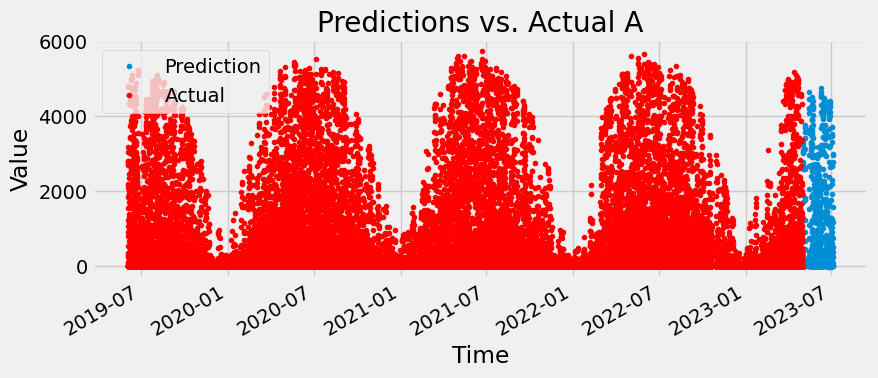

In [265]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

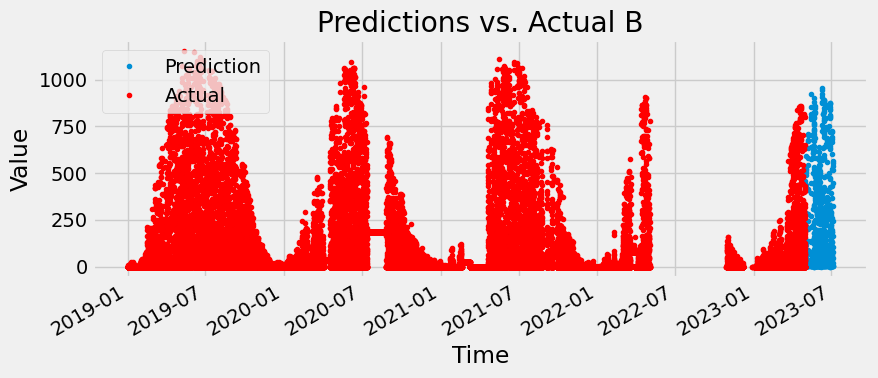

In [266]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


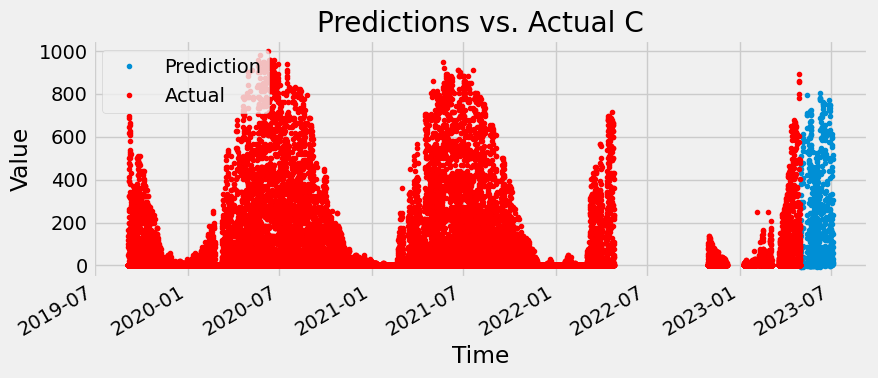

In [267]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

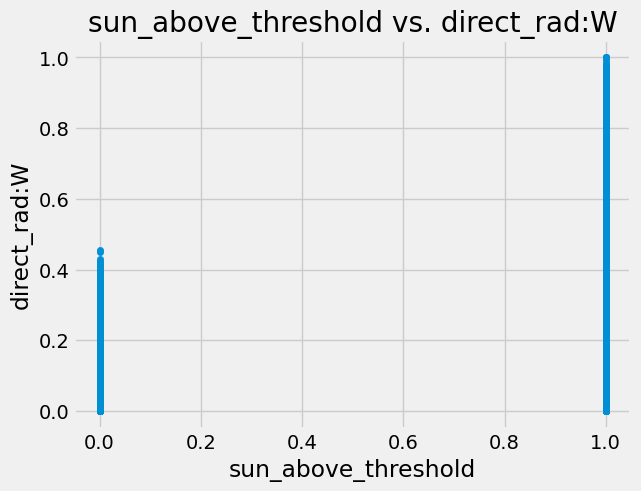

In [268]:
df.plot(x='sun_above_threshold', y='pv_measurement', kind='scatter')
plt.xlabel('sun_above_threshold')
plt.ylabel('direct_rad:W')
plt.title('sun_above_threshold vs. direct_rad:W')
plt.show()